# Competition: Binary Classification with a Bank Churn Dataset
Playground Series - Season 4, Episode 1

### Goal
The Task is to predict whether a customer continues with their account or closes it (e.g., churns). 

### Evaluation Metrics
Area under the ROC curve between the predicted probability and the observed target

## Dataset Exploration

Importing necessary libraries

In [1]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

Loading the datasets

In [2]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [3]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# for train_df
df_info = pd.DataFrame(data={
    'Column' : train_df.columns,
    'Dtype' : train_df.dtypes,
    'Unique' : train_df.nunique(),
    'Not null' : train_df.count(),
    'Missing' : train_df.isnull().sum(),
    '% Missing' : train_df.isnull().sum()*100/len(train_df)
}).reset_index(drop=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_info.style.background_gradient(cmap='coolwarm'))

,Column,Dtype,Unique,Not null,Missing,% Missing
0,id,int64,165034,165034,0,0.000000
1,CustomerId,int64,23221,165034,0,0.000000
2,Surname,object,2797,165034,0,0.000000
3,CreditScore,int64,457,165034,0,0.000000
4,Geography,object,3,165034,0,0.000000
5,Gender,object,2,165034,0,0.000000
6,Age,float64,71,165034,0,0.000000
7,Tenure,int64,11,165034,0,0.000000
8,Balance,float64,30075,165034,0,0.000000
9,NumOfProducts,int64,4,165034,0,0.000000


In [5]:
# for test_df
df_info = pd.DataFrame(data={
    'Column' : test_df.columns,
    'Dtype' : test_df.dtypes,
    'Unique' : test_df.nunique(),
    'Not null' : test_df.count(),
    'Missing' : test_df.isnull().sum(),
    '% Missing' : test_df.isnull().sum()*100/len(test_df)
}).reset_index(drop=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_info.style.background_gradient(cmap='coolwarm'))

,Column,Dtype,Unique,Not null,Missing,% Missing
0,id,int64,110023,110023,0,0.000000
1,CustomerId,int64,19698,110023,0,0.000000
2,Surname,object,2708,110023,0,0.000000
3,CreditScore,int64,454,110023,0,0.000000
4,Geography,object,3,110023,0,0.000000
5,Gender,object,2,110023,0,0.000000
6,Age,float64,74,110023,0,0.000000
7,Tenure,int64,11,110023,0,0.000000
8,Balance,float64,22513,110023,0,0.000000
9,NumOfProducts,int64,4,110023,0,0.000000


### Initial Conclusion
1. `id` is not required for model training, but it is necessary for final submission
2. `Surname` has lots of unique value, and usually it is not that useful for model prediction
3. The other categorical variables, `Geography` and `Gender` can be converted using one hot encoder
4. `Age`, `HasCrCard` and `isActiveMember` should be integer values
5. Notice `HasCrCard,` and `IsActiveMember` are not really a numerical features. Instead, they are binary categories signifying if the customer has a credit card and if he is an active member, respectively. 

In [6]:
train_df_cleaned = train_df.drop(columns=['id','CustomerId','Surname'])
submissionIds = test_df['id']
test_df_cleaned = test_df.drop(columns=['id','CustomerId','Surname'])

train_df_cleaned[['Age']] = train_df_cleaned[['Age']].astype('int')
test_df_cleaned[['Age']] = test_df_cleaned[['Age']].astype('int')

train_df_cleaned[['HasCrCard', 'IsActiveMember']] = train_df_cleaned[[ 'HasCrCard' , 'IsActiveMember']].astype('object')
test_df_cleaned[[ 'HasCrCard', 'IsActiveMember']] = test_df_cleaned[['HasCrCard', 'IsActiveMember']].astype('object')

In [7]:
get_cat_features = lambda df: df.select_dtypes(include=['object']).columns.to_list()
get_num_features = lambda df: df.select_dtypes(include=['number']).columns.to_list()

In [8]:
cat_features = get_cat_features(train_df_cleaned)  
num_features = get_num_features(train_df_cleaned)  
y_col = 'Exited'  # our target columns

num_features.remove(y_col)

print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")
print(f"Target column: {y_col}")

Categorical features: ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
Numerical features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Target column: Exited


## Exploatory Data Analysis

### Target Distribution

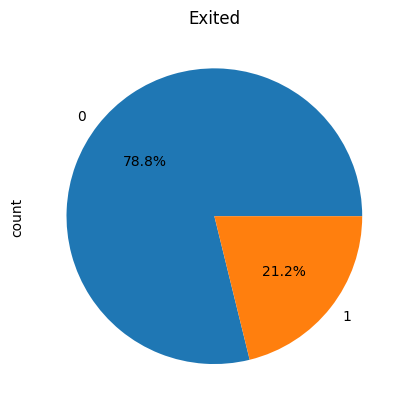

In [9]:
train_df[y_col].value_counts().plot.pie(autopct='%1.1f%%')
plt.title(y_col);

Note only 21% of the data has Exited=1, meaning the dataset is imbalanced. We will address this later.

### Categorical feature distributions

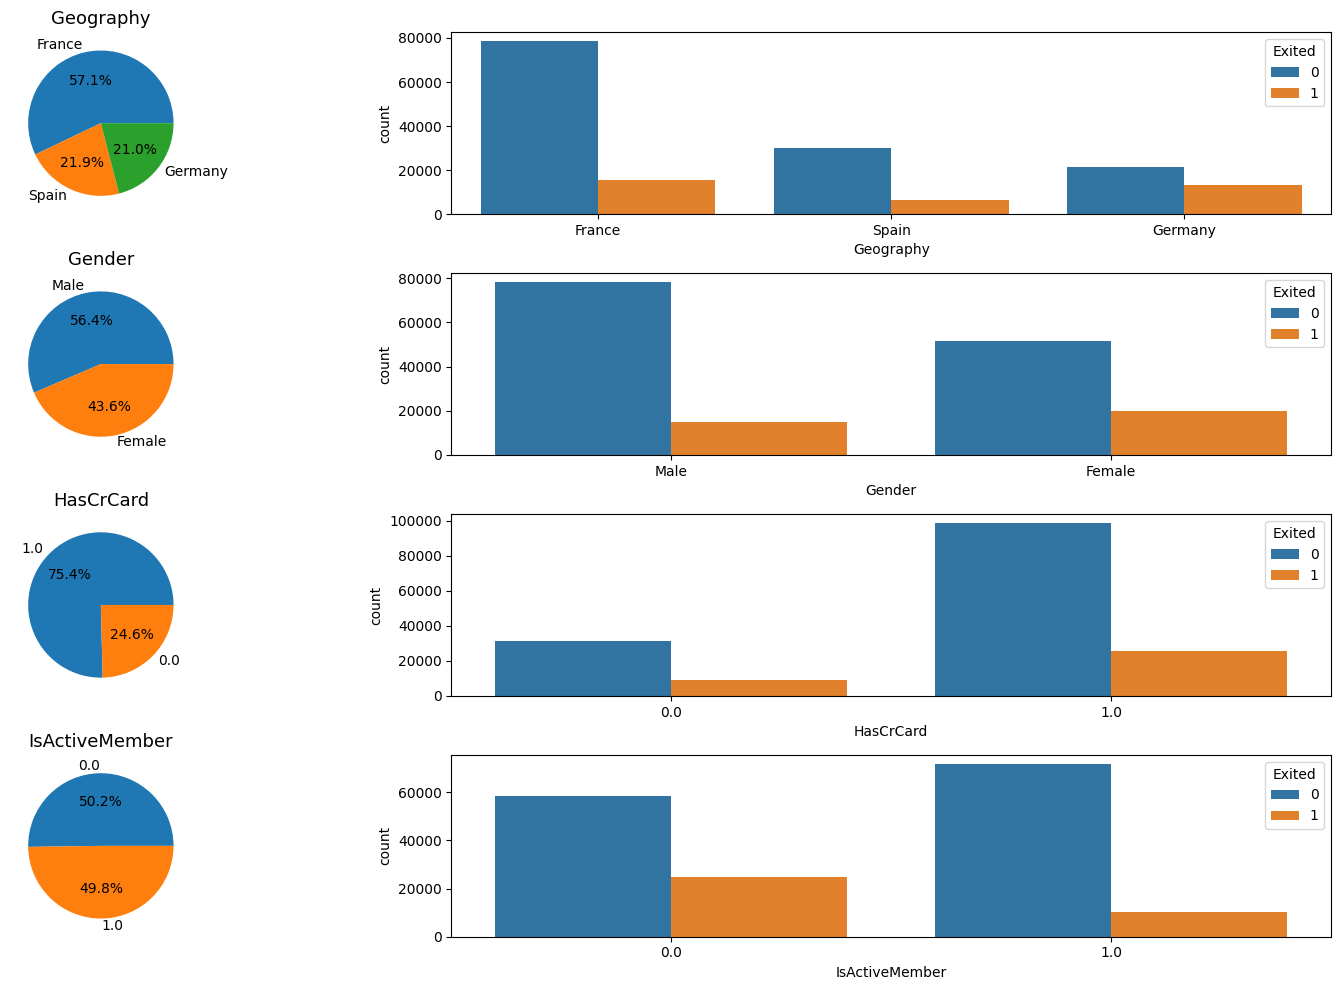

In [10]:
f,axes = plt.subplots(len(cat_features),2,figsize=(17,10))

for (ax1,ax2),c in zip(axes,cat_features):
    t = train_df_cleaned[c].value_counts().plot.pie(ax=ax1,autopct='%1.1f%%')
    ax1.set_title(c,fontsize=13)
    ax1.set_ylabel('')
    sns.countplot(data=train_df, x=c, hue=y_col, ax=ax2)

plt.tight_layout()

### Numerical feature distribution

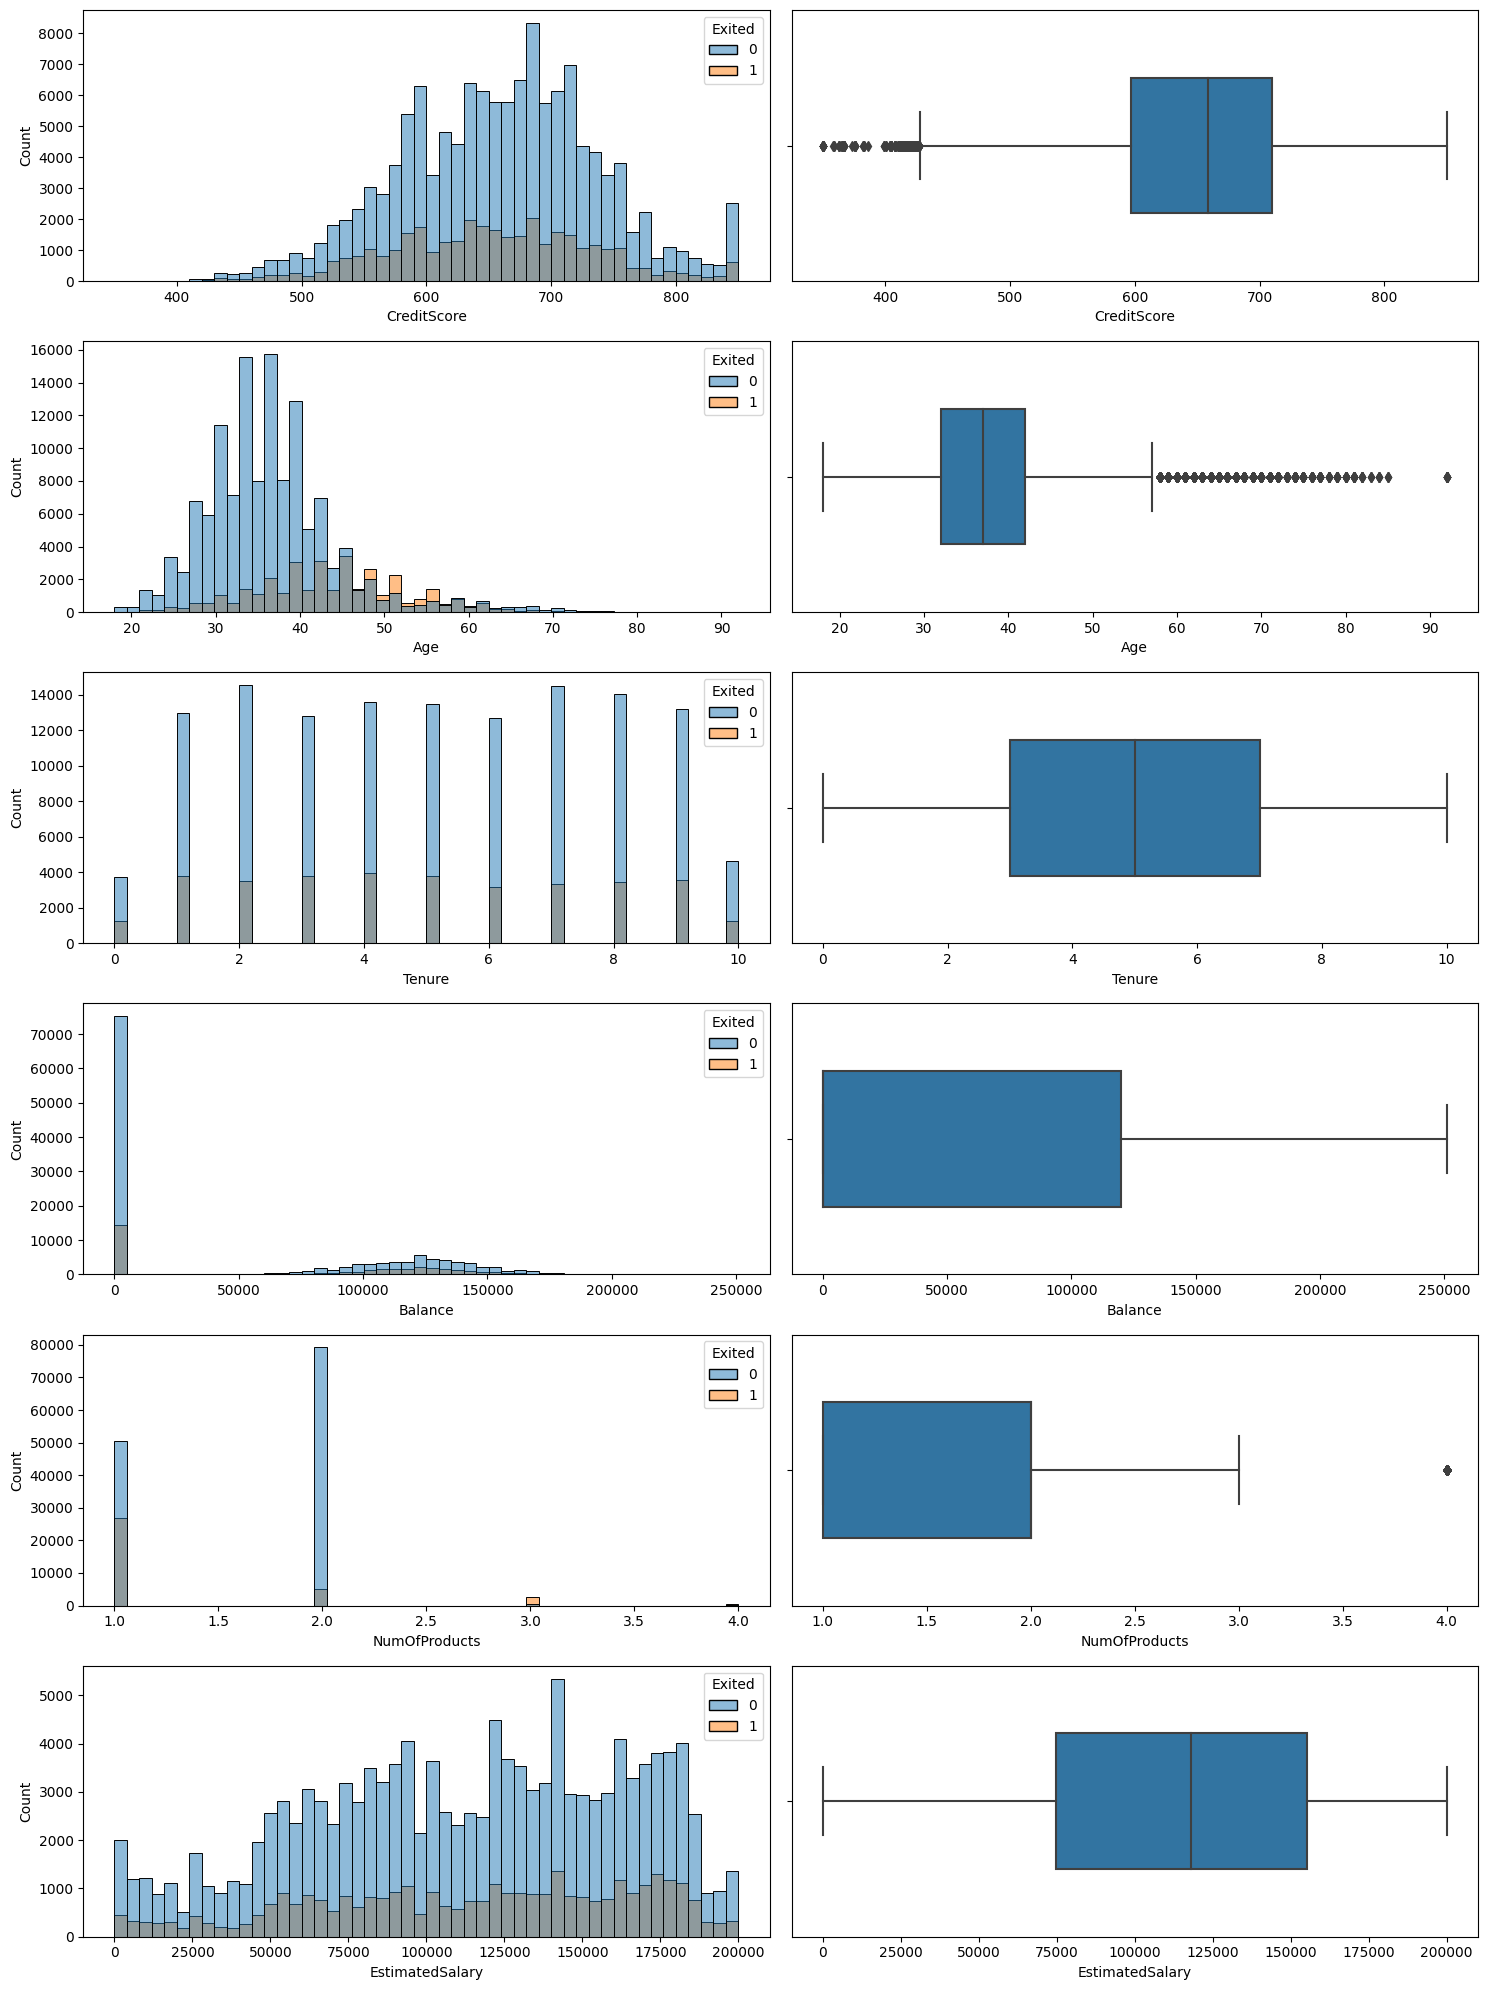

In [11]:
f,axes = plt.subplots(len(num_features),2,figsize=(15,20))

for (ax1,ax2),c in zip(axes,num_features):
    sns.histplot(data=train_df_cleaned, x=c, hue=y_col, bins=50, kde=False, ax=ax1)
    sns.boxplot(data=train_df_cleaned, x=c, hue=y_col, width=0.5, ax=ax2) #, gap=0.2

plt.tight_layout()

## Train Test Split

In [12]:
df1 = train_df_cleaned.copy()

X = df1.drop(y_col, axis=1)
y = df1[y_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=111)

## Building pipeline

In [13]:
# returns the pipeline for a particular classifier model
def getPipeline(classifier):
  numerical_transformer = Pipeline(steps=[
      ('scaler', PowerTransformer())
  ])

  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False))
  ])


  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numerical_transformer, get_num_features(X_train)),
          ('cat', categorical_transformer, get_cat_features(X_train))
      ])

  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', classifier)
  ])

  return pipeline

# Fits and predict our classifier model
def fitAndPredict(pipeline, X_t, y_t, X_v, y_v):
  pipeline.fit(X_t, y_t)
  y_pred = pipeline.predict(X_v)
  return accuracy_score(y_v, y_pred)

### Iterating models

In [14]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=111),
    XGBClassifier(random_state=111),
    LGBMClassifier(random_state=111,verbosity=-1)
];
pipelines = [getPipeline(i) for i in classifiers]

In [15]:
for pipeline in pipelines:
    # display(dtc_pipeline)
    accuracy = fitAndPredict(pipeline, X_train, y_train, X_val, y_val)
    print(f"Accuracy for {pipeline['classifier'].__class__.__name__} :{accuracy}")

Accuracy for DecisionTreeClassifier :0.7964068227951646
Accuracy for RandomForestClassifier :0.8594540552004121
Accuracy for XGBClassifier :0.8652104099130488
Accuracy for LGBMClassifier :0.8668161299118369


### Cross Validation

In [16]:
best_pipeline = pipelines[-1]

In [17]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=111)
score = cross_val_score(best_pipeline, X_train, y_train, verbose=0, cv=skf)
print(score)

[0.86753011 0.86904491 0.86874195 0.86162236 0.86745437 0.86813603
 0.86684844 0.86199061 0.8611574  0.86471747]


The accuracy scores all varies in a overall close range, so our model has low variance and did not overfit.

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26128
           1       0.74      0.56      0.64      6879

    accuracy                           0.87     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.87      0.86     33007



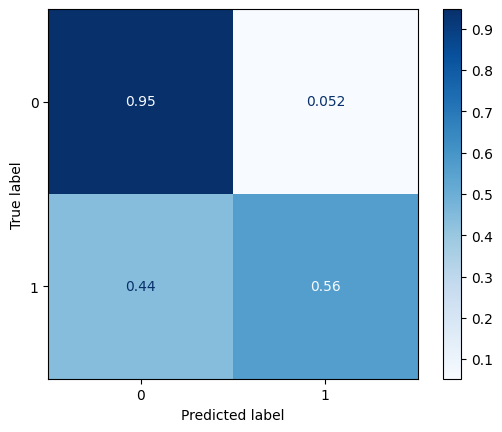

In [18]:
y_pred = best_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, normalize='true')).plot(cmap=plt.cm.Blues);

Notice that our model works well in identifying non-Exited entries. But works very poorly for Exited=1 entries

### ROC-AUC

AUC score: 0.889


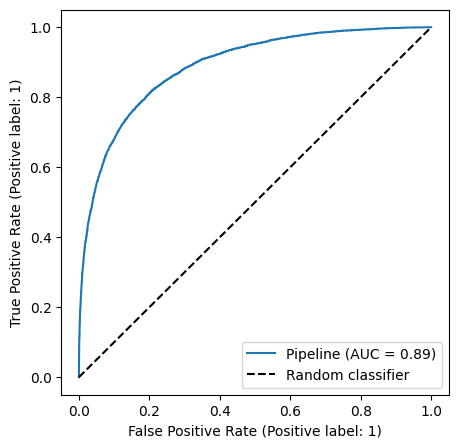

In [19]:
fig,ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_estimator(best_pipeline, X_val, y_val,ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.legend()
print(f"AUC score: {svc_disp.roc_auc:.3f}")

## Handling imbalance in dataset

We noticed earlier that our dataset performs poorly for Exited=1 values because there is very little data for Exited=1 (21%) compared to Exited=0. To address this imbalance, we will use imlearn.

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

smt = SMOTE(random_state=111)

In [21]:
# sklearn pipeline do not work with SMOTE, we need to use the pipeline from the imblearn library
def getImbPipeline(classifier):
  numerical_transformer = imbPipeline(steps=[
      ('scaler', PowerTransformer())
  ])


  categorical_transformer = imbPipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False))
  ])


  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numerical_transformer, get_num_features(X_train)),
          ('cat', categorical_transformer, get_cat_features(X_train))
      ])

  pipeline = imbPipeline([
      ('preprocessor', preprocessor),
      ('smt',smt),
      ('classifier', classifier)
  ])

  return pipeline

In [22]:
newPipeLine = getImbPipeline(LGBMClassifier(random_state=111,verbosity=-1))
display(newPipeLine)
fitAndPredict(newPipeLine, X_train, y_train, X_val, y_val)  # accuracy

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   PowerTransformer())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('smt', SMOTE(random_state=111)),
                ('classifier', LGBMClassifier(random_state=111, verbosity=-1))])

0.8636955797255128

Confusion matrix after balancing the data

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     26128
           1       0.69      0.63      0.66      6879

    accuracy                           0.86     33007
   macro avg       0.80      0.78      0.79     33007
weighted avg       0.86      0.86      0.86     33007



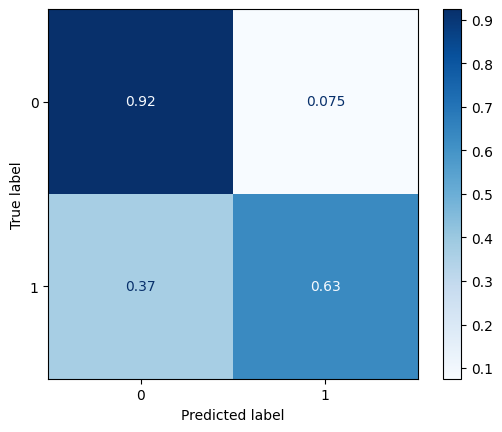

In [23]:
y_pred = newPipeLine.predict(X_val)
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, normalize='true')).plot(cmap=plt.cm.Blues);

AUC score: 0.888


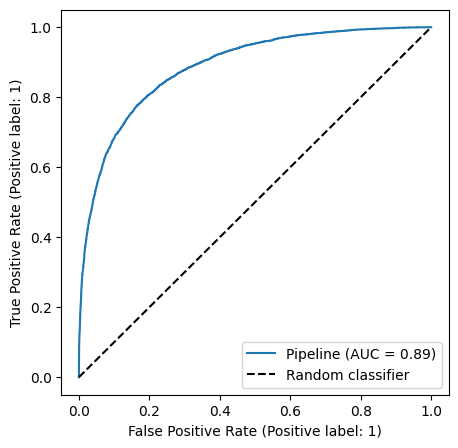

In [24]:
fig,ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_estimator(newPipeLine, X_val, y_val,ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.legend()
print(f"AUC score: {svc_disp.roc_auc:.3f}")

Well, the overall accuracy and AUC score of our balanced model have been slightly reduced, but the new model performs slightly better for Exited=1 values.

## Feature Importance

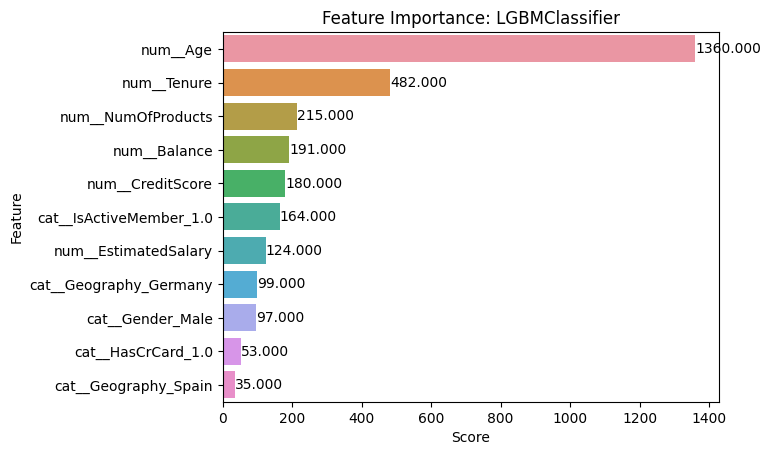

In [25]:
feature_scores = pd.Series(newPipeLine['classifier'].feature_importances_, index=newPipeLine['preprocessor'].get_feature_names_out()).sort_values(ascending=False)

ax  = sns.barplot(x=feature_scores[:15], y=feature_scores.index[:15])
for container in ax.containers: ax.bar_label(container, fmt = "%.3f")
plt.title(f'Feature Importance: {newPipeLine["classifier"].__class__.__name__}')
plt.xlabel('Score')
plt.ylabel('Feature');

### Submission

In [26]:
submit_df = pd.DataFrame({
    'id': submissionIds,
    y_col: newPipeLine.predict(test_df_cleaned)
})
submit_df.to_csv('submission.csv', index=False)